# Introduction


Greetings! This notebook is dedicated to a thorough Exploratory Data Analysis (EDA) of our dataset. Through visualizations and insightful observations, I aim to provide a deeper understanding of the images and masks, exploring the distribution of images with and without ships. Additionally, I will analyze the count of ships per image, unraveling the intricacies of our dataset.

In [1]:
import os
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Load data

In [2]:
sample_submission = pd.read_csv('../data/sample_submission_v2.csv')
train_segmentations = pd.read_csv('../data/train_ship_segmentations_v2.csv')

In [3]:
print(f'Number of train samples: {train_segmentations.shape[0]}')
train_segmentations.head()

Number of train samples: 231723


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


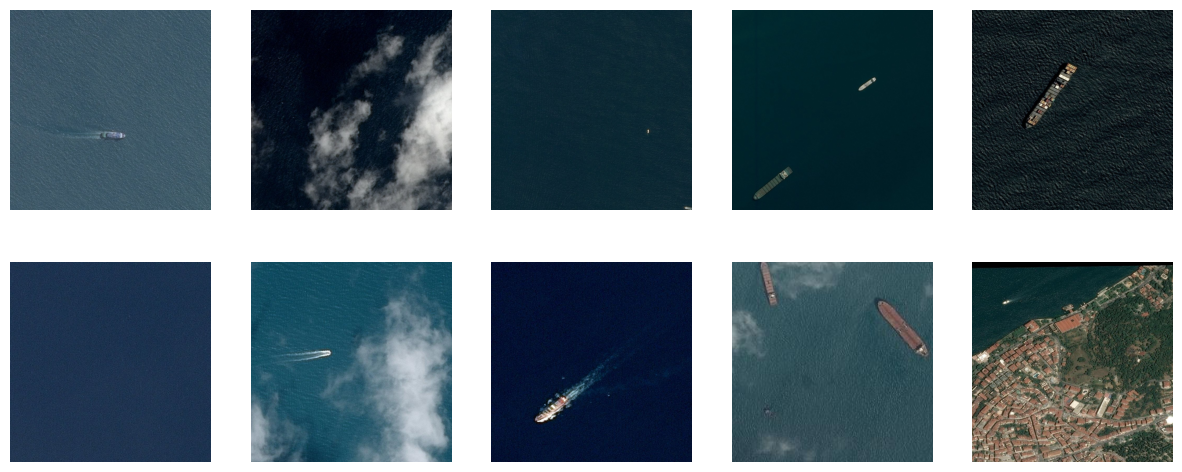

In [4]:
def display_images(folder_path, num_images=10, num_columns=5):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Calculate the number of rows needed
    num_rows = (num_images + num_columns - 1) // num_columns

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)
        row_index, col_index = divmod(i, num_columns)
        axes[row_index, col_index].imshow(img)
        axes[row_index, col_index].axis('off')

    plt.show()

folder_path = '../data/images'
display_images(folder_path, num_images=10, num_columns=5)

# Run-length encoding (RLE)

To minimize the submission file size, the metric employs run-length encoding on pixel values. Consequently, it becomes necessary to define functions for both encoding and decoding processes.

In [5]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if type(mask_rle) != str:
        return np.zeros(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T  # Needed to align to RLE direction

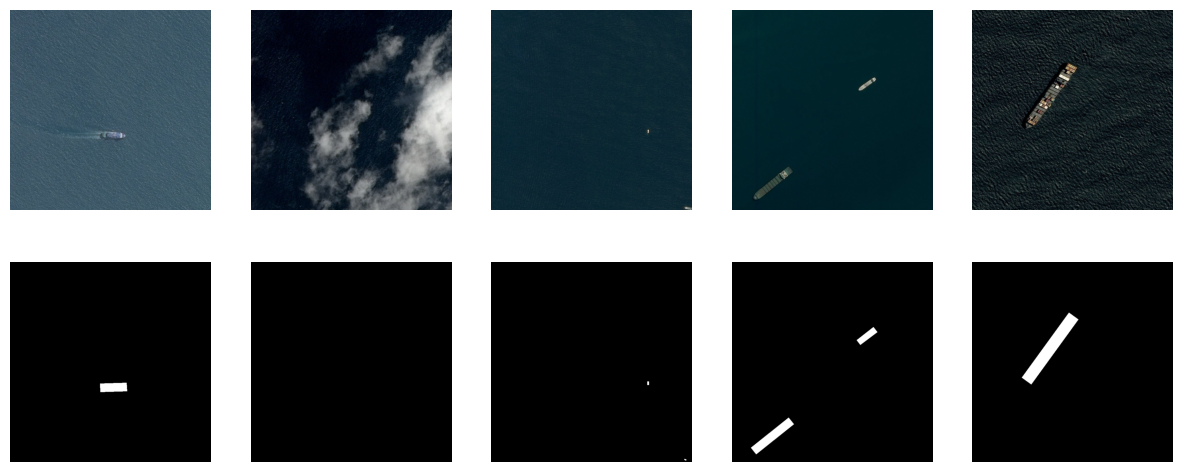

In [6]:
def display_masks(folder_path, num_images=5):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Calculate the number of rows needed
    num_rows = 2

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_images, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)

        all_masks = train_segmentations[train_segmentations['ImageId'] == image_files[i]].EncodedPixels
        mask = np.zeros((768, 768))
        for m in all_masks:
            mask += rle_decode(m)
        
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].axis('off')
    
    plt.savefig('../reports/visualizations/train_image_mask_pairs.png', bbox_inches='tight')
    plt.show()

folder_path = '../data/images'
display_masks(folder_path, num_images=5)

# Images without ships

In [7]:
images_with_ships = train_segmentations[train_segmentations.EncodedPixels.notna()].ImageId.nunique()
images_without_ships = train_segmentations[train_segmentations.EncodedPixels.isna()].ImageId.nunique()

print(f'Number of images with ships    - {images_with_ships}  | {round(images_with_ships / train_segmentations.ImageId.nunique() * 100)}%')
print(f'Number of images without ships - {images_without_ships} | {round(images_without_ships / train_segmentations.ImageId.nunique() * 100)}%')

Number of images with ships    - 42556  | 22%
Number of images without ships - 150000 | 78%


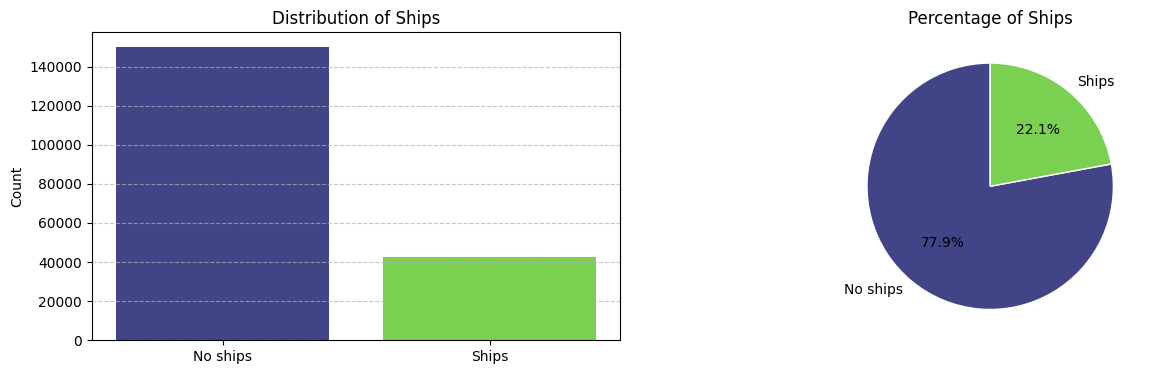

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot bar chart
axes[0].bar(['No ships', 'Ships'], [images_without_ships, images_with_ships], color=plt.cm.viridis([0.2, 0.8]))
axes[0].set_title('Distribution of Ships')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot pie chart
axes[1].pie([images_without_ships, images_with_ships], labels=['No ships', 'Ships'], autopct='%1.1f%%',
            startangle=90, colors=plt.cm.viridis([0.2, 0.8]), wedgeprops={"linewidth": 1, "edgecolor": "white"})
axes[1].set_title('Percentage of Ships')
axes[1].set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Display the plot
plt.show()

# Number of Ships Distribution

In [9]:
n_ships_df = train_segmentations.dropna().groupby('ImageId').count()
n_ships_df.rename({'EncodedPixels': 'n_ships'}, axis='columns', inplace=True)

n_ships_df.describe()

,n_ships
count,42556.000000
mean,1.920364
std,1.906073
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


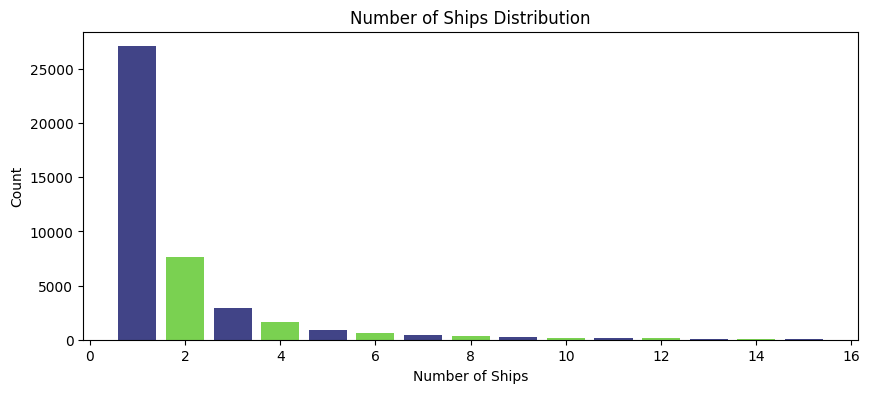

In [10]:
plt.figure(figsize=(10, 4))
plt.title('Number of Ships Distribution')
plt.xlabel('Number of Ships')
plt.ylabel('Count')
plt.bar(range(1, 16), n_ships_df.n_ships.value_counts(), color=plt.cm.viridis([0.2, 0.8]));

In [11]:
n_ships_df.n_ships.value_counts()

n_ships
1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: count, dtype: int64